<a href="https://colab.research.google.com/github/acharyariku/PyTorch-Training/blob/main/PyTorch_Exercise_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.__version__

'2.6.0+cu124'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
torch.manual_seed(42)

from sklearn.datasets import make_moons

X,y = make_moons(n_samples = 1000)

X,y = torch.from_numpy(X).type(torch.float),torch.from_numpy(y).type(torch.float)

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)



In [ ]:
from torch import nn
class myModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=25)
    self.layer3 = nn.Linear(in_features=25,out_features=1)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model0 = myModel().to(device)
model0

myModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=25, bias=True)
  (layer3): Linear(in_features=25, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),lr=0.1)

In [ ]:
def accuracy_fn(y,y_pred):
  count = torch.eq(y,y_pred).sum().item()
  acc = count/len(y_pred)
  return acc*100

In [ ]:
epochs = 1000

X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

for epoch in range(epochs):

  model0.train()

  y_logits = model0(X_train).squeeze()
  y_pred = torch.sigmoid(y_logits)
  y_pred_labels = torch.round(y_pred)

  acc = accuracy_fn(y_train.int(),y_pred_labels)

  loss = loss_fn(y_logits,y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_labels = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_labels, y_test.int())

  # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.2f} Acc: {acc:.2f} | Test loss: {test_loss:.2f} Test acc: {test_acc:.2f}")


Epoch: 0 | Loss: 0.68 Acc: 50.00 | Test loss: 0.68 Test acc: 50.00
Epoch: 100 | Loss: 0.35 Acc: 83.50 | Test loss: 0.37 Test acc: 81.50
Epoch: 200 | Loss: 0.24 Acc: 89.38 | Test loss: 0.29 Test acc: 86.00
Epoch: 300 | Loss: 0.20 Acc: 91.38 | Test loss: 0.26 Test acc: 88.50
Epoch: 400 | Loss: 0.17 Acc: 92.88 | Test loss: 0.22 Test acc: 89.50
Epoch: 500 | Loss: 0.13 Acc: 95.00 | Test loss: 0.17 Test acc: 92.00
Epoch: 600 | Loss: 0.09 Acc: 97.12 | Test loss: 0.12 Test acc: 96.00
Epoch: 700 | Loss: 0.05 Acc: 99.25 | Test loss: 0.07 Test acc: 99.00
Epoch: 800 | Loss: 0.03 Acc: 100.00 | Test loss: 0.05 Test acc: 100.00
Epoch: 900 | Loss: 0.02 Acc: 100.00 | Test loss: 0.03 Test acc: 100.00


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(model,X,y):
  model = model.to("cpu")
  X,y = X.to("cpu"),y.to("cpu")

  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                        np.linspace(y_min, y_max, 101))

  # Make features
  X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

  # Make predictions
  model.eval()
  with torch.inference_mode():
      y_logits = model(X_to_pred_on)

  # Test for multi-class or binary and adjust logits to prediction labels
  if len(torch.unique(y)) > 2:
      y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
  else:
      y_pred = torch.round(torch.sigmoid(y_logits)) # binary

  # Reshape preds and plot
  y_pred = y_pred.reshape(xx.shape).detach().numpy()
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

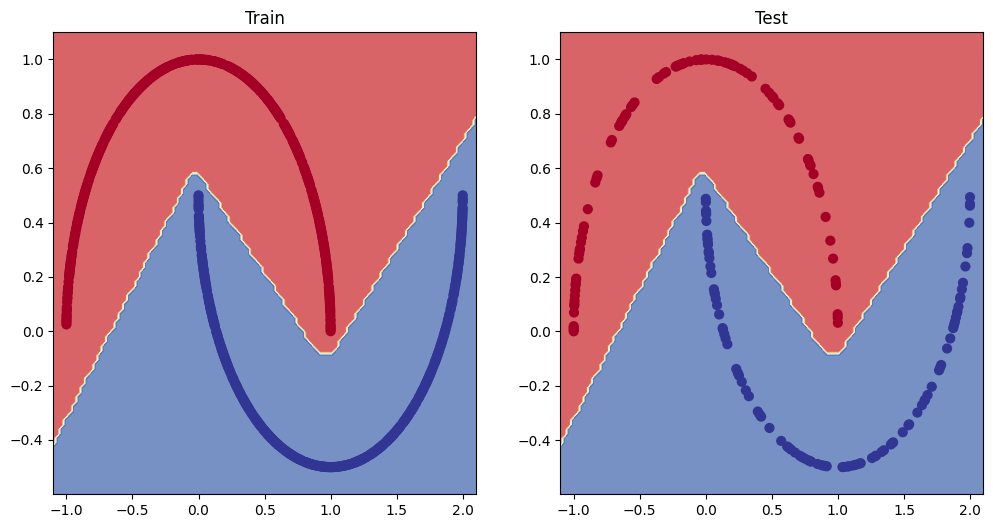

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_predictions(model0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_predictions(model0, X_test, y_test)

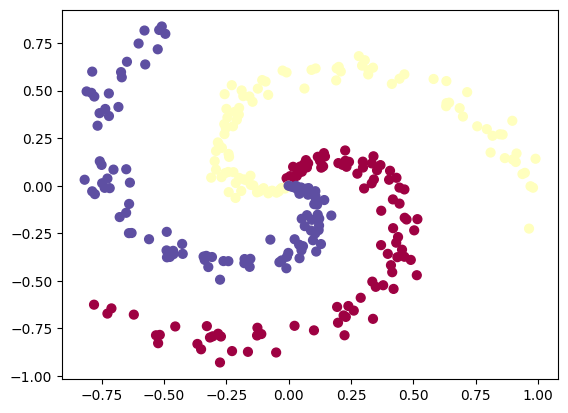

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [ ]:
class SpiralModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(in_features=2,out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=10)
    self.layer3 = nn.Linear(in_features=10,out_features=3)
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))

model1 = SpiralModel().to(device)
model1

SpiralModel(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),lr=0.02)

In [ ]:
X,y = torch.from_numpy(X).type(torch.float),torch.from_numpy(y).type(torch.long)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)

In [ ]:
epochs = 1000

X_train,X_test,y_train,y_test = X_train.to(device),X_test.to(device),y_train.to(device),y_test.to(device)

for epoch in range(epochs):

  model1.train()

  y_logits = model1(X_train)
  y_pred = torch.softmax(y_logits,dim=1).argmax(dim=1)
  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_train,y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model1.eval()

  with torch.inference_mode():
    test_logits = model1(X_test)
    test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
    test_loss = loss_fn(test_logits,y_test)

    if epoch%100 == 0:
      print(accuracy_fn(y_test,test_pred))



40.0
88.33333333333333
91.66666666666666
91.66666666666666
96.66666666666667
98.33333333333333
98.33333333333333
98.33333333333333
98.33333333333333
98.33333333333333


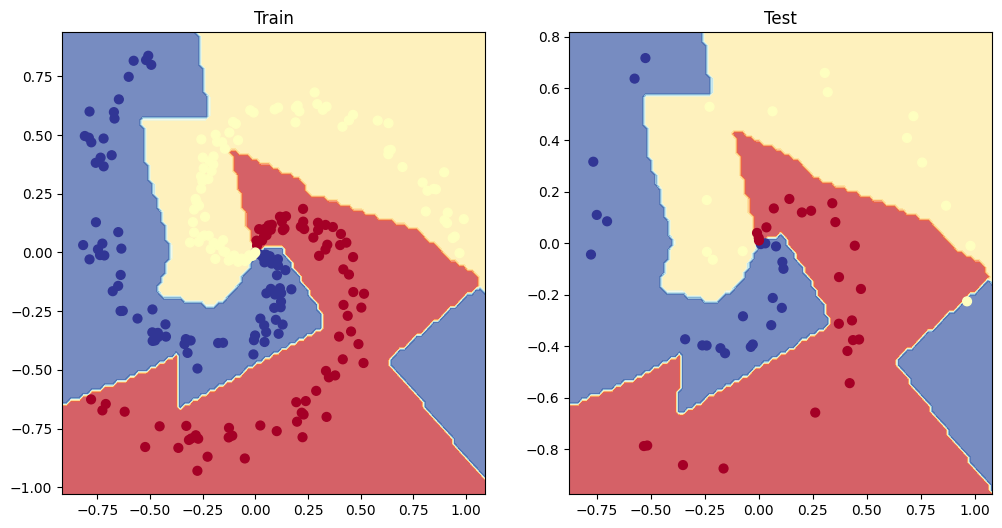

In [ ]:

# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_predictions(model1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_predictions(model1, X_test, y_test)